In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [ ]:
# load data
# in the later real work, more data will be loaded. So data between different years can be compared
# but in this demo, for the computing convenience, only the 2021 data will be used

In [2]:
# df2015 = pd.read_csv('Turnstile_Usage_Data__2015.csv')
# df2016 = pd.read_csv('Turnstile_Usage_Data__2016.csv')
# df2017 = pd.read_csv('Turnstile_Usage_Data__2017.csv')
# df2018 = pd.read_csv('Turnstile_Usage_Data__2018.csv')
# df2019 = pd.read_csv('Turnstile_Usage_Data__2019.csv')
# df2020 = pd.read_csv('Turnstile_Usage_Data__2020.csv')
df2021 = pd.read_csv('Turnstile_Usage_Data__2021.csv')

In [3]:
df2021.columns

Index(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date',
       'Time', 'Description', 'Entries',
       'Exits                                                     '],
      dtype='object')

In [4]:
# 'Exits' label has extra space, clean it out

In [6]:
df2021.columns = df2021.columns.str.replace(' ', '')

In [8]:
# make a copy
# when loading all the data (2015-2020), it takes a long time. Having a copy makes data processing more easily when something went wrong

In [9]:
df2021_copy = df2021.copy()

In [ ]:
# add 2 more columns: 
# 'Turnstile' is to identify a unique turnstile. The data is accumulated, so we need to find a specific turnstile to calculate the entries/exits.
# 'Datetime' is to combine the date and time for the convenience of data processing

In [10]:
df2021_copy['Turnstile'] = df2021_copy['C/A'] + ' ' + df2021_copy['Unit'] + ' ' + df2021_copy['SCP'] + ' ' + df2021_copy['Station']
df2021_copy['Datetime'] = pd.to_datetime(df2021_copy['Date'] + ' ' + df2021_copy['Time'], format='%m/%d/%Y %H:%M:%S')

In [11]:
df2021_copy.Turnstile.unique().shape

(5032,)

In [12]:
# there are 5032 unique turnstiles

In [ ]:
# remove some duplicated rows, as explained in MTA documents (because of many kinds of reasons)

In [13]:
df2021_copy.drop_duplicates(subset=['Turnstile', 'Datetime'], inplace=True)

In [ ]:
# sort the dataframe with turnstile and datetime.

In [14]:
df2021_copy_sort_datetime = df2021_copy.groupby(['Turnstile', 'Datetime'],as_index=False).first()

In [ ]:
# creat new columns 'Datetime_prev', 'Entries_prev', 'Exits_prev' to store the last (~) record for a specific turnstile

In [16]:
df2021_copy_sort_datetime[['Datetime_prev', 'Entries_prev', 'Exits_prev']] = \
    df2021_copy_sort_datetime.groupby(['Turnstile'])[['Datetime', 
                                                      'Entries', 'Exits']].apply(lambda row: row.shift(1))

In [ ]:
# drop the NA data, those are the rows at the beginning of 2021 which don't have a last record (however, it will have one when input 2020 data)

In [17]:
df2021_copy_sort_datetime.dropna(inplace=True)

In [ ]:
# calculate the entries/exits change in that time period

In [20]:
df2021_copy_sort_datetime['Entries_change'] = df2021_copy_sort_datetime['Entries'] - df2021_copy_sort_datetime['Entries_prev']
df2021_copy_sort_datetime['Exits_change'] = df2021_copy_sort_datetime['Exits'] - df2021_copy_sort_datetime['Exits_prev']

In [ ]:
# calculate the time period

In [21]:
df2021_copy_sort_datetime['Duration_hr'] = (df2021_copy_sort_datetime['Datetime'] - df2021_copy_sort_datetime['Datetime_prev']) / pd.Timedelta('1h')

In [ ]:
# calculate the hourly average entries/exits change

In [22]:
df2021_copy_sort_datetime['Entries_change_hourly'] = df2021_copy_sort_datetime['Entries_change'] / df2021_copy_sort_datetime['Duration_hr']
df2021_copy_sort_datetime['Exits_change_hourly'] = df2021_copy_sort_datetime['Exits_change'] / df2021_copy_sort_datetime['Duration_hr']

In [23]:
# reorder the column names

In [25]:
df2021_copy_sort_datetime = df2021_copy_sort_datetime[['Turnstile', 'Datetime_prev','Datetime', 'Duration_hr',
                                         'Entries_prev', 'Entries', 'Entries_change', 'Entries_change_hourly',
                                         'Exits_prev', 'Exits', 'Exits_change', 'Exits_change_hourly',
                                         'C/A', 'Unit', 'SCP', 'Station', 
                                         'LineName', 'Division', 'Date','Time', 'Description']]

In [26]:
pd.options.display.max_rows = 1000
pd.set_option('display.max_columns', None)

In [28]:
df2021_copy_sort_datetime.head(1000)

Turnstile       Datetime_prev            Datetime  \
1     A002 R051 02-00-00 59 ST 2021-01-02 03:00:00 2021-01-02 07:00:00   
2     A002 R051 02-00-00 59 ST 2021-01-02 07:00:00 2021-01-02 11:00:00   
3     A002 R051 02-00-00 59 ST 2021-01-02 11:00:00 2021-01-02 15:00:00   
4     A002 R051 02-00-00 59 ST 2021-01-02 15:00:00 2021-01-02 19:00:00   
5     A002 R051 02-00-00 59 ST 2021-01-02 19:00:00 2021-01-02 23:00:00   
6     A002 R051 02-00-00 59 ST 2021-01-02 23:00:00 2021-01-03 03:00:00   
7     A002 R051 02-00-00 59 ST 2021-01-03 03:00:00 2021-01-03 07:00:00   
8     A002 R051 02-00-00 59 ST 2021-01-03 07:00:00 2021-01-03 11:00:00   
9     A002 R051 02-00-00 59 ST 2021-01-03 11:00:00 2021-01-03 15:00:00   
10    A002 R051 02-00-00 59 ST 2021-01-03 15:00:00 2021-01-03 19:00:00   
11    A002 R051 02-00-00 59 ST 2021-01-03 19:00:00 2021-01-03 23:00:00   
12    A002 R051 02-00-00 59 ST 2021-01-03 23:00:00 2021-01-04 03:00:00   
13    A002 R051 02-00-00 59 ST 2021-01-04 03:00:00 2021-01-04 07:00:00   
14    A002 R051 02-00-00 59 ST 2021-01-04 07:00:00 2021-01-04 11:00:00   
15    A002 R051 02-00-00 59 ST 2021-01-04 11:00:00 2021-01-04 15:00:00   
16    A002 R051 02-00-00 59 ST 2021-01-04 15:00:00 2021-01-04 19:00:00   
17    A002 R051 02-00-00 59 ST 2021-01-04 19:00:00 2021-01-04 23:00:00   
18    A002 R051 02-00-00 59 ST 2021-01-04 23:00:00 2021-01-05 03:00:00   
19    A002 R051 02-00-00 59 ST 2021-01-05 03:00:00 2021-01-05 07:00:00   
20    A002 R051 02-00-00 59 ST 2021-01-05 07:00:00 2021-01-05 11:00:00   
21    A002 R051 02-00-00 59 ST 2021-01-05 11:00:00 2021-01-05 15:00:00   
22    A002 R051 02-00-00 59 ST 2021-01-05 15:00:00 2021-01-05 19:00:00   
23    A002 R051 02-00-00 59 ST 2021-01-05 19:00:00 2021-01-05 23:00:00   
24    A002 R051 02-00-00 59 ST 2021-01-05 23:00:00 2021-01-06 03:00:00   
25    A002 R051 02-00-00 59 ST 2021-01-06 03:00:00 2021-01-06 07:00:00   
26    A002 R051 02-00-00 59 ST 2021-01-06 07:00:00 2021-01-06 11:00:00   
27    A002 R051 02-00-00 59 ST 2021-01-06 11:00:00 2021-01-06 15:00:00   
28    A002 R051 02-00-00 59 ST 2021-01-06 15:00:00 2021-01-06 19:00:00   
29    A002 R051 02-00-00 59 ST 2021-01-06 19:00:00 2021-01-06 23:00:00   
30    A002 R051 02-00-00 59 ST 2021-01-06 23:00:00 2021-01-07 03:00:00   
31    A002 R051 02-00-00 59 ST 2021-01-07 03:00:00 2021-01-07 07:00:00   
32    A002 R051 02-00-00 59 ST 2021-01-07 07:00:00 2021-01-07 11:00:00   
33    A002 R051 02-00-00 59 ST 2021-01-07 11:00:00 2021-01-07 15:00:00   
34    A002 R051 02-00-00 59 ST 2021-01-07 15:00:00 2021-01-07 19:00:00   
35    A002 R051 02-00-00 59 ST 2021-01-07 19:00:00 2021-01-07 23:00:00   
36    A002 R051 02-00-00 59 ST 2021-01-07 23:00:00 2021-01-08 03:00:00   
37    A002 R051 02-00-00 59 ST 2021-01-08 03:00:00 2021-01-08 07:00:00   
38    A002 R051 02-00-00 59 ST 2021-01-08 07:00:00 2021-01-08 11:00:00   
39    A002 R051 02-00-00 59 ST 2021-01-08 11:00:00 2021-01-08 15:00:00   
40    A002 R051 02-00-00 59 ST 2021-01-08 15:00:00 2021-01-08 19:00:00   
41    A002 R051 02-00-00 59 ST 2021-01-08 19:00:00 2021-01-08 23:00:00   
42    A002 R051 02-00-00 59 ST 2021-01-08 23:00:00 2021-01-09 03:00:00   
43    A002 R051 02-00-00 59 ST 2021-01-09 03:00:00 2021-01-09 07:00:00   
44    A002 R051 02-00-00 59 ST 2021-01-09 07:00:00 2021-01-09 11:00:00   
45    A002 R051 02-00-00 59 ST 2021-01-09 11:00:00 2021-01-09 15:00:00   
46    A002 R051 02-00-00 59 ST 2021-01-09 15:00:00 2021-01-09 19:00:00   
47    A002 R051 02-00-00 59 ST 2021-01-09 19:00:00 2021-01-09 23:00:00   
48    A002 R051 02-00-00 59 ST 2021-01-09 23:00:00 2021-01-10 03:00:00   
49    A002 R051 02-00-00 59 ST 2021-01-10 03:00:00 2021-01-10 07:00:00   
50    A002 R051 02-00-00 59 ST 2021-01-10 07:00:00 2021-01-10 11:00:00   
51    A002 R051 02-00-00 59 ST 2021-01-10 11:00:00 2021-01-10 15:00:00   
52    A002 R051 02-00-00 59 ST 2021-01-10 15:00:00 2021-01-10 19:00:00   
53    A002 R051 02-00-00 59 ST 2021-01-10 19:00:00 2021-01-10 23:00:00   
54    A002 R051 02-00-00 

In [29]:
# for some reason, there are negative changes in both entries and exits.
# for this demo work, I just simply remove those lines

In [30]:
df2021_copy_sort_datetime = df2021_copy_sort_datetime[df2021_copy_sort_datetime['Entries_change'] >= 0]
df2021_copy_sort_datetime = df2021_copy_sort_datetime[df2021_copy_sort_datetime['Exits_change'] >= 0]

In [31]:
df2021_copy_sort_datetime.shape

(2685677, 21)

In [ ]:
# still have 2685677 rows of data

In [ ]:
# need to add up all the turnstile data (at each time) in the same station

In [41]:
df2021_copy_station = df2021_copy_sort_datetime.groupby(['Station', 'Datetime'], 
                                                        as_index=False)[['Entries_change', 'Exits_change', 
                                                                         'Entries_change_hourly', 
                                                                         'Exits_change_hourly']].agg('sum')

In [34]:
# since not all the turnstile upload data at the same time, but the majority of them update every 4 hours
# so, cut the data into 6 periods for the convenience of data processing

In [42]:
df2021_copy_station['Timegrp'] = pd.cut(
    pd.to_datetime(df2021_copy_station.Datetime), 
    pd.period_range(start='2021-01-02 00:00:00', end='2021-06-19 00:00:00', freq='4H').to_timestamp())

In [ ]:
# combine the data during the same time period at the same station

In [43]:
df2021_copy_station = df2021_copy_station.groupby(['Station', 'Timegrp'])[['Entries_change', 'Exits_change', 
                                                                         'Entries_change_hourly', 
                                                                         'Exits_change_hourly']].agg('sum')

In [44]:
df2021_copy_station

Entries_change  \
Station   Timegrp                                                      
1 AV      (2021-01-02, 2021-01-02 04:00:00]                      0.0   
          (2021-01-02 04:00:00, 2021-01-02 08:00:00]            47.0   
          (2021-01-02 08:00:00, 2021-01-02 12:00:00]           429.0   
          (2021-01-02 12:00:00, 2021-01-02 16:00:00]          1020.0   
          (2021-01-02 16:00:00, 2021-01-02 20:00:00]          1353.0   
...                                                              ...   
ZEREGA AV (2021-06-18 04:00:00, 2021-06-18 08:00:00]            26.0   
          (2021-06-18 08:00:00, 2021-06-18 12:00:00]           479.0   
          (2021-06-18 12:00:00, 2021-06-18 16:00:00]           211.0   
          (2021-06-18 16:00:00, 2021-06-18 20:00:00]           285.0   
          (2021-06-18 20:00:00, 2021-06-19]                    147.0   

                                                      Exits_change  \
Station   Timegrp                                                    
1 AV      (2021-01-02, 2021-01-02 04:00:00]                    0.0   
          (2021-01-02 04:00:00, 2021-01-02 08:00:00]         231.0   
          (2021-01-02 08:00:00, 2021-01-02 12:00:00]         943.0   
          (2021-01-02 12:00:00, 2021-01-02 16:00:00]        1844.0   
          (2021-01-02 16:00:00, 2021-01-02 20:00:00]        1954.0   
...                                                            ...   
ZEREGA AV (2021-06-18 04:00:00, 2021-06-18 08:00:00]          33.0   
          (2021-06-18 08:00:00, 2021-06-18 12:00:00]         202.0   
          (2021-06-18 12:00:00, 2021-06-18 16:00:00]         180.0   
          (2021-06-18 16:00:00, 2021-06-18 20:00:00]         336.0   
          (2021-06-18 20:00:00, 2021-06-19]                  424.0   

                                                      Entries_change_hourly  \
Station   Timegrp                                                             
1 AV      (2021-01-02, 2021-01-02 04:00:00]                            0.00   
          (2021-01-02 04:00:00, 2021-01-02 08:00:00]                  11.75   
          (2021-01-02 08:00:00, 2021-01-02 12:00:00]                 107.25   
          (2021-01-02 12:00:00, 2021-01-02 16:00:00]                 255.00   
          (2021-01-02 16:00:00, 2021-01-02 20:00:00]                 338.25   
...                                                                     ...   
ZEREGA AV (2021-06-18 04:00:00, 2021-06-18 08:00:00]                   6.50   
          (2021-06-18 08:00:00, 2021-06-18 12:00:00]                 119.75   
          (2021-06-18 12:00:00, 2021-06-18 16:00:00]                  52.75   
          (2021-06-18 16:00:00, 2021-06-18 20:00:00]                  71.25   
          (2021-06-18 20:00:00, 2021-06-19]                           36.75   

                                                      Exits_change_hourly  
Station   Timegrp                                                          
1 AV      (2021-01-02, 2021-01-02 04:00:00]                          0.00  
          (2021-01-02 04:00:00, 2021-01-02 08:00:00]                57.75  
          (2021-01-02 08:00:00, 2021-01-02 12:00:00]               235.75  
          (2021-01-02 12:00:00, 2021-01-02 16:00:00]               461.00  
          (2021-01-02 16:00:00, 2021-01-02 20:00:00]               488.50  
...                                                                   ...  
ZEREGA AV (2021-06-18 04:00:00, 2021-06-18 08:00:00]                 8.25  
          (2021-06-18 08:00:00, 2021-06-18 12:00:00]                50.50  
          (2021-06-18 12:00:00, 2021-06-18 16:00:00]                45.00  
          (2021-06-18 16:00:00, 2021-06-18 20:00:00]                84.00  
          (2021-06-18 20:00:00, 2021-06-19]                        106.00  

[382032 rows x 4 columns]

In [45]:
# for now, focus on the entry data

In [105]:
df2021_copy_station_entries = df2021_copy_station[['Entries_change_hourly']]

In [106]:
df2021_copy_station_entries

Entries_change_hourly
Station   Timegrp                                                          
1 AV      (2021-01-02, 2021-01-02 04:00:00]                            0.00
          (2021-01-02 04:00:00, 2021-01-02 08:00:00]                  11.75
          (2021-01-02 08:00:00, 2021-01-02 12:00:00]                 107.25
          (2021-01-02 12:00:00, 2021-01-02 16:00:00]                 255.00
          (2021-01-02 16:00:00, 2021-01-02 20:00:00]                 338.25
...                                                                     ...
ZEREGA AV (2021-06-18 04:00:00, 2021-06-18 08:00:00]                   6.50
          (2021-06-18 08:00:00, 2021-06-18 12:00:00]                 119.75
          (2021-06-18 12:00:00, 2021-06-18 16:00:00]                  52.75
          (2021-06-18 16:00:00, 2021-06-18 20:00:00]                  71.25
          (2021-06-18 20:00:00, 2021-06-19]                           36.75

[382032 rows x 1 columns]

In [ ]:
# unstack for plotting purpose

In [66]:
df2021_copy_station_entries_plt = df2021_copy_station_entries.unstack(level = 0)

In [70]:
df2021_copy_station_entries_plt

Entries_change_hourly           \
Station                                                     1 AV   103 ST   
Timegrp                                                                     
(2021-01-02, 2021-01-02 04:00:00]                       0.000000     6.50   
(2021-01-02 04:00:00, 2021-01-02 08:00:00]             11.750000    91.50   
(2021-01-02 08:00:00, 2021-01-02 12:00:00]            107.250000   267.00   
(2021-01-02 12:00:00, 2021-01-02 16:00:00]            255.000000   445.75   
(2021-01-02 16:00:00, 2021-01-02 20:00:00]            338.250000   362.75   
...                                                          ...      ...   
(2021-06-18 04:00:00, 2021-06-18 08:00:00]            109.250000    18.00   
(2021-06-18 08:00:00, 2021-06-18 12:00:00]            356.250000   511.75   
(2021-06-18 12:00:00, 2021-06-18 16:00:00]            586.750000   695.75   
(2021-06-18 16:00:00, 2021-06-18 20:00:00]            890.500495  1034.75   
(2021-06-18 20:00:00, 2021-06-19]                       0.000000   777.25   

                                                                          \
Station                                    103 ST-CORONA  104 ST  110 ST   
Timegrp                                                                    
(2021-01-02, 2021-01-02 04:00:00]                   0.00    0.00    0.00   
(2021-01-02 04:00:00, 2021-01-02 08:00:00]        162.50   26.75   24.75   
(2021-01-02 08:00:00, 2021-01-02 12:00:00]        495.00   68.75   30.25   
(2021-01-02 12:00:00, 2021-01-02 16:00:00]        395.00   70.25  141.00   
(2021-01-02 16:00:00, 2021-01-02 20:00:00]        354.75   52.50  160.00   
...                                                  ...     ...     ...   
(2021-06-18 04:00:00, 2021-06-18 08:00:00]        982.25  205.00  163.25   
(2021-06-18 08:00:00, 2021-06-18 12:00:00]        799.25  123.50  314.50   
(2021-06-18 12:00:00, 2021-06-18 16:00:00]        563.25   92.75  325.50   
(2021-06-18 16:00:00, 2021-06-18 20:00:00]        421.50   68.00  304.25   
(2021-06-18 20:00:00, 2021-06-19]                   0.00    0.00    0.00   

                                                                             \
Station                                     111 ST   116 ST 116 ST-COLUMBIA   
Timegrp                                                                       
(2021-01-02, 2021-01-02 04:00:00]             0.25    10.00            4.00   
(2021-01-02 04:00:00, 2021-01-02 08:00:00]  147.75   117.00            8.25   
(2021-01-02 08:00:00, 2021-01-02 12:00:00]  387.75   330.50           33.50   
(2021-01-02 12:00:00, 2021-01-02 16:00:00]  311.00   521.25           64.25   
(2021-01-02 16:00:00, 2021-01-02 20:00:00]  243.00   440.50           63.25   
...                                            ...      ...             ...   
(2021-06-18 04:00:00, 2021-06-18 08:00:00]  796.25    33.75            3.75   
(2021-06-18 08:00:00, 2021-06-18 12:00:00]  707.00   663.50           60.25   
(2021-06-18 12:00:00, 2021-06-18 16:00:00]  423.50   728.00          130.50   
(2021-06-18 16:00:00, 2021-06-18 20:00:00]  319.75  1048.50          277.75   
(2021-06-18 20:00:00, 2021-06-19]            28.50   824.50          178.50   

                                                                    \
Station                                    121 ST   125 ST  135 ST   
Timegrp                                                              
(2021-01-02, 2021-01-02 04:00:00]            0.00    22.75    1.00   
(2021-01-02 04:00:00, 2021-01-02 08:00:00]  10.75   184.75   38.00   
(2021-01-02 08:00:00, 2021-01-02 12:00:00]  39.00   595.00  142.25   
(2021-01-02 12:00:00, 2021-01-02 16:00:00]  33.75  1142.75  220.50   
(2021-01-02 16:00:00, 2021-01-02 20:00:00]  35.50  1113.50  183.50   
...                                           ...      ...     ...   
(2021-06-18 04:00:00, 2021-06-18 08:00:00]  68.75   435.00  134.50   
(2021-06-18 08:00:00, 2021-06-18 12:00:00]  54.25  1416.00  340.00   
(2021-06-18 12:00:00, 

In [ ]:
# load station location data

In [57]:
df_station_location = pd.read_csv('station_location.csv')
df_station_location.columns = df_station_location.columns.str.replace(' ', '_')

In [59]:
# only need the GFTS data

In [60]:
dsl_geo = df_station_location[['Stop_Name', 'GTFS_Latitude', 'GTFS_Longitude']].copy()

In [ ]:
# input the hourly average entries change, link with the GFTS data
# (note that this method is not very accurate, since the station names are not exactly the same in the two dataframes, even they both come from MTA)
# (in the latter work, the station name match needs to be fine-tuned)

In [83]:
dsl_geo.sort_values(by='Stop_Name', inplace=True)
dsl_geo.drop_duplicates('Stop_Name', inplace=True)
dsl_geo['Average_Entries'] = df2021_copy_station_entries_plt.iloc[0].values.copy()

In [84]:
dsl_geo

Stop_Name  GTFS_Latitude  GTFS_Longitude  \
118                                   1 Av      40.730953      -73.981628   
395                                 103 St      40.790600      -73.947478   
450                    103 St-Corona Plaza      40.749865      -73.862700   
81                                  104 St      40.695178      -73.844330   
394                                 110 St      40.795020      -73.944250   
194                                 111 St      40.684331      -73.832163   
153                                 116 St      40.805085      -73.954882   
307             116 St-Columbia University      40.807722      -73.964110   
79                                  121 St      40.700492      -73.828294   
306                                 125 St      40.815581      -73.958372   
438                                 135 St      40.814229      -73.940770   
305                    137 St-City College      40.822008      -73.953676   
391                 138 St-Grand Concourse      40.813224      -73.929849   
322                                  14 St      40.737826      -74.000201   
14                          14 St-Union Sq      40.735736      -73.990568   
116                        14 St-Union Sq.      40.734789      -73.990730   
149                                 145 St      40.824783      -73.944216   
435                 149 St-Grand Concourse      40.818410      -73.926718   
241                    15 St-Prospect Park      40.660365      -73.979493   
148                                 155 St      40.830518      -73.941514   
303                                 157 St      40.834041      -73.944890   
389                  161 St-Yankee Stadium      40.827994      -73.925831   
147                    163 St-Amsterdam Av      40.836013      -73.939892   
388                                 167 St      40.835537      -73.921400   
146                                 168 St      40.840719      -73.939561   
302                  168 St-Washington Hts      40.840556      -73.940133   
255                                 169 St      40.710470      -73.793604   
387                                 170 St      40.840075      -73.917791   
428                                 174 St      40.837288      -73.887734   
216                            174-175 Sts      40.845900      -73.910136   
145                                 175 St      40.847391      -73.939704   
385                                 176 St      40.848480      -73.911794   
245                                  18 Av      40.629755      -73.976971   
321                                  18 St      40.741040      -73.997871   
144                                 181 St      40.851695      -73.937969   
214                            182-183 Sts      40.856093      -73.900741   
383                                 183 St      40.858407      -73.903879   
143                                 190 St      40.859022      -73.934180   
300                                 191 St      40.855225      -73.929412   
232                                   2 Av      40.723402      -73.989938   
66                                   20 Av      40.604556      -73.998168   
298                                 207 St      40.864621      -73.918822   
282                                  21 St      40.744065      -73.949724   
221                     21 St-Queensbridge      40.754203      -73.942836   
297                                 215 St      40.869444      -73.915279   
420                                 219 St      40.883895      -73.862633   
419                                 225 St      40.888022      -73.860341   
164                                  23 St      40.745906      -73.998041   
295                                 231 St      40.878856      -73.904834   
418                                 233 St      40.893193      -73.857473   
294                                 238 St      40.884667      -73.900870   
68                           

In [85]:
# creat a bubble map showing how many commuters are entering subway stations at a certain time period
# here, the example is (2021-01-02 00:00:00, 2021-01-02 04:00:00]

In [86]:
# make an empty map

In [87]:
m = folium.Map(location=[40.754222,-73.984569], tiles="OpenStreetMap", zoom_start=11)

In [88]:
# add bubbles

In [89]:
for i in range(0,dsl_geo.shape[0]):
   folium.CircleMarker(
      location=[dsl_geo.iloc[i]['GTFS_Latitude'], dsl_geo.iloc[i]['GTFS_Longitude']],
      popup=dsl_geo.iloc[i]['Stop_Name'],
      radius=float(dsl_geo.iloc[i]['Average_Entries'])/10,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

In [90]:
# show the bubble map

In [91]:
m

In [ ]:
# now we see how many commuters are entering subway stations city-wide between (2021-01-02 00:00:00, 2021-01-02 04:00:00]

In [98]:
df2021_copy_station_entries.reset_index(inplace=True)

In [100]:
df2021_copy_station_entries

Station                                     Timegrp  \
0            1 AV           (2021-01-02, 2021-01-02 04:00:00]   
1            1 AV  (2021-01-02 04:00:00, 2021-01-02 08:00:00]   
2            1 AV  (2021-01-02 08:00:00, 2021-01-02 12:00:00]   
3            1 AV  (2021-01-02 12:00:00, 2021-01-02 16:00:00]   
4            1 AV  (2021-01-02 16:00:00, 2021-01-02 20:00:00]   
...           ...                                         ...   
382027  ZEREGA AV  (2021-06-18 04:00:00, 2021-06-18 08:00:00]   
382028  ZEREGA AV  (2021-06-18 08:00:00, 2021-06-18 12:00:00]   
382029  ZEREGA AV  (2021-06-18 12:00:00, 2021-06-18 16:00:00]   
382030  ZEREGA AV  (2021-06-18 16:00:00, 2021-06-18 20:00:00]   
382031  ZEREGA AV           (2021-06-18 20:00:00, 2021-06-19]   

        Entries_change_hourly  
0                        0.00  
1                       11.75  
2                      107.25  
3                      255.00  
4                      338.25  
...                       ...  
382027                   6.50  
382028                 119.75  
382029                  52.75  
382030                  71.25  
382031                  36.75  

[382032 rows x 3 columns]

In [123]:
Station_list = df2021_copy_sort_datetime.Station.unique()

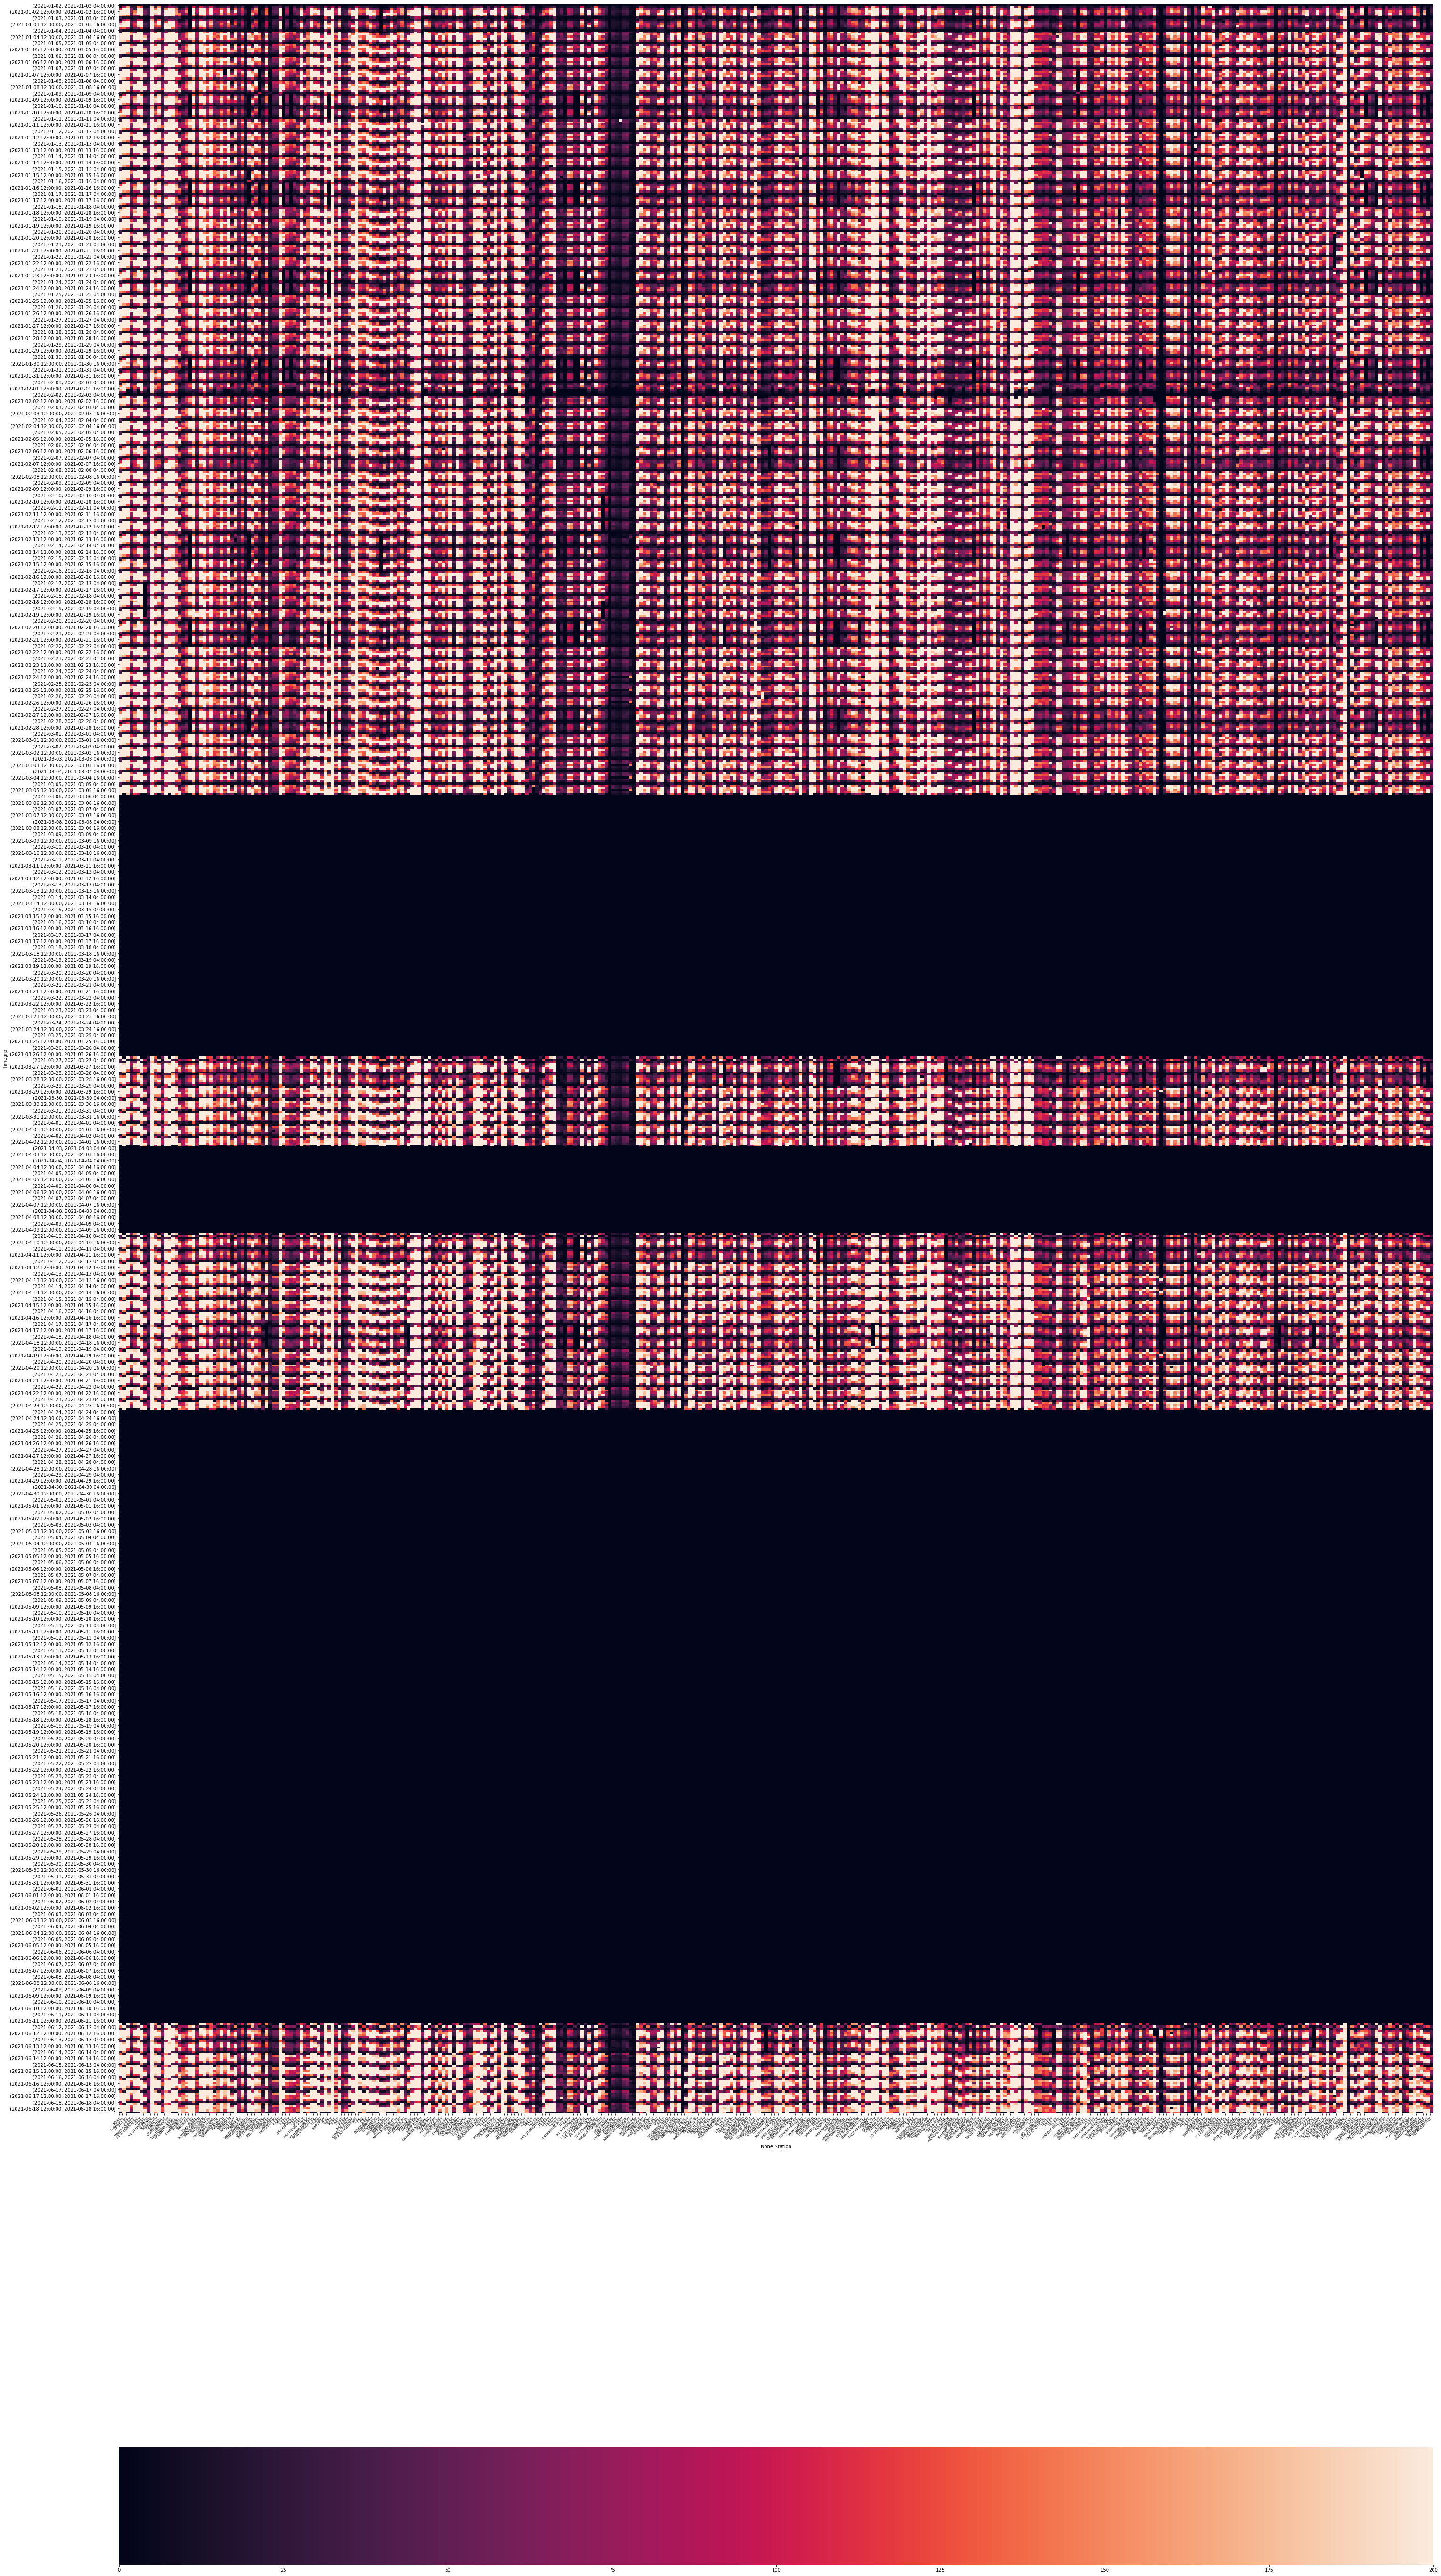

In [137]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(50,100))
ax = sns.heatmap(df2021_copy_station_entries_plt, ax=ax, vmax=200,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})
ax.set_xticks(np.arange(len(Station_list)))
ax.set_xticklabels(Station_list)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", size=7,
         rotation_mode="anchor")
plt.show()

In [ ]:
# this a heatmap of the hourly average entries data at different station in 2021.
# (the black part is lack of data)
# double click for original size
# this heatmap can be plotted by using part of the data for better visual effect and more accurate conclutions (e.g. for a specific station or train line)
# can also plot frequency trails